<a href="https://colab.research.google.com/github/lyzno1/lightning_example/blob/main/CIFAR10_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lightning

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import torch
import torch.nn as nn
import lightning as L
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import torchvision


100%|██████████| 170498071/170498071 [00:04<00:00, 34515631.55it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


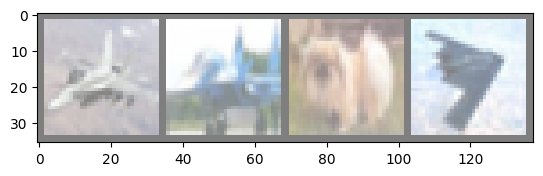

In [3]:
# prompt: load the cifar10 and look at the first image

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))


In [21]:
class CIFARDataModule(L.LightningDataModule):

    def __init__(self, config):
        super().__init__()
        self.data_dir = config.data_dir
        self.transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),  # 随机水平翻转
            transforms.RandomCrop(32, padding=4),  # 随机裁剪
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 颜色抖动
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.batch_size = config.batch_size
        self.num_workers = config.num_workers
        self.seed = config.seed

    def prepare_data(self):
        CIFAR10(self.data_dir, train=True, download=True)
        CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        L.seed_everything(self.seed)
        if stage == 'fit' or stage is None:
            train_and_val_data = CIFAR10(self.data_dir, train=True, transform=self.transform)
            self.train_data, self.val_data = torch.utils.data.random_split(
                train_and_val_data, [int(len(train_and_val_data)*0.8), int(len(train_and_val_data)*0.2)],
                generator=torch.Generator().manual_seed(self.seed)
            )
        if stage == 'test' or stage is None:
            self.test_data = CIFAR10(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, num_workers=self.num_workers)

In [22]:
from sklearn.metrics import f1_score

class LitClassifier(L.LightningModule):

  def __init__(self, config):
      super().__init__()
      self.config = config

      # 加载预训练的 ResNet50 模型
      self.resnet = torchvision.models.resnet50(pretrained=True)

      # 只冻结早期层
      for name, param in self.resnet.named_parameters():
          if 'layer4' not in name:  # 冻结layer4之前的层
              param.requires_grad = False

      # 自定义分类器头
      self.resnet.fc = nn.Sequential(
          nn.Linear(self.resnet.fc.in_features, 512),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(256, self.config.num_classes)
      )

  def forward(self, x):
        return self.resnet(x)

  def training_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss = F.cross_entropy(logits, y)
    self.log('train_loss', loss, prog_bar=True, on_epoch=True)
    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss = F.cross_entropy(logits, y)
    self.log('val_loss', loss, prog_bar=True, on_epoch=True)
    return loss

  def test_step(self, batch, batch_idx):
    x, y = batch
    logits = self(x)
    loss = F.cross_entropy(logits, y)
    y_hat = torch.argmax(logits, dim=1)
    f1 = f1_score(y.cpu().numpy(), y_hat.cpu().numpy(), average='micro') # Change average to 'micro'
    self.log_dict({"test_loss": loss, "f1_score": f1}, prog_bar=True, on_epoch=True)
    return loss

  def configure_optimizers(self):
    return torch.optim.Adam(self.parameters(), lr=self.config.lr)

In [23]:
from dataclasses import dataclass

@dataclass
class Config:
  data_dir: str = './data'
  batch_size: int = 64
  num_workers: int = 4
  seed: int = 42
  num_classes: int = 10
  lr: float = 1e-3

config = Config()
config

Config(data_dir='./data', batch_size=64, num_workers=4, seed=42, num_classes=10, lr=0.001)

In [24]:
model = LitClassifier(config)
datamodule = CIFARDataModule(config)

trainer = L.Trainer(max_epochs=10, accelerator='auto')
trainer.fit(model, datamodule)
trainer.test(model, datamodule)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPU

Files already downloaded and verified
Files already downloaded and verified


INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type   | Params | Mode 
------------------------------------------
0 | resnet | ResNet | 24.7 M | train
------------------------------------------
16.1 M    Trainable params
8.5 M     Non-trainable params
24.7 M    Total params
98.764    Total estimated model params size (MB)
158       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name   | Type   | Params | Mode 
------------------------------------------
0 | resnet | ResNet | 24.7 M | train
------------------------------------------
16.1 M    Trainable params
8.5 M     Non-trainable params
24.7 M    Total params
98.764    Total estimated model params size (MB)
158       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


Files already downloaded and verified
Files already downloaded and verified


INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         f1_score          │    0.6948000192642212     │
│         test_loss         │    0.8982598781585693     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8982598781585693, 'f1_score': 0.6948000192642212}]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


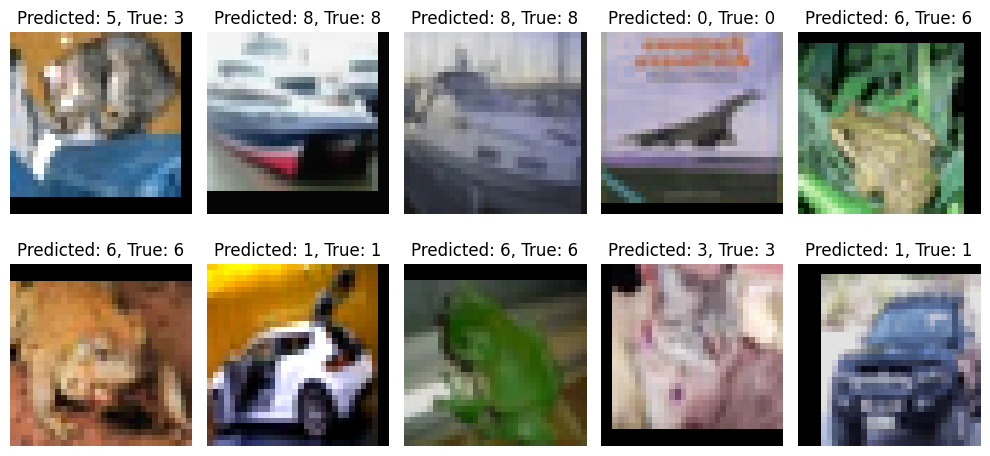

In [25]:
# prompt: use datamodule's test data to predict and visualize the results and image
import matplotlib.pyplot as plt

test_dataloader = datamodule.test_dataloader()

images, labels = next(iter(test_dataloader))

model.eval()

with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))
for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(images[i].permute(1, 2, 0).numpy() / 2 + 0.5)  # 反规范化图像
    ax.set_title(f"Predicted: {predicted[i]}, True: {labels[i]}")
    ax.axis('off')
plt.tight_layout()
plt.show()
